Computing true value function via iterative policy evaluation...
Running Gradient MC with state aggregation...
Running Gradient MC with polynomial basis (order=5)...
Running Gradient MC with Fourier basis (order=5)...


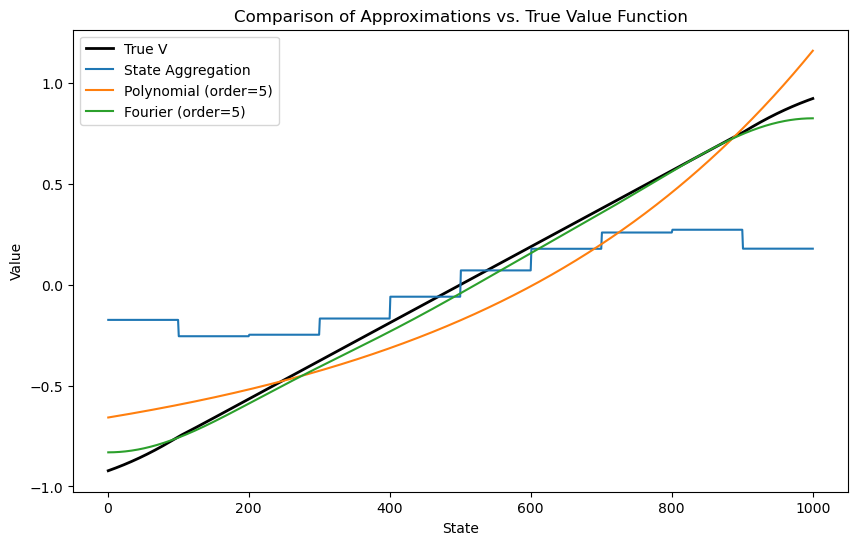

RMS Error - State Aggregation: 0.3688
RMS Error - Polynomial Basis:  0.1442
RMS Error - Fourier Basis:     0.0348


In [1]:
import numpy as np
import matplotlib.pyplot as plt


class RandomWalk1000:


    def __init__(self, n_states=1000, n_neighbors=100):
        self.n_states = n_states
        self.n_neighbors = n_neighbors
        self.start_state = 500  # the problem statement suggests starting near center

    def reset(self):
        return self.start_state

    def step(self, state):

        left_missing = 0
        right_missing = 0
        valid_next = []  # valid non-terminal next states

        for offset in range(1, self.n_neighbors + 1):
            ns = state - offset
            if ns < 1:
                left_missing += 1
            else:
                valid_next.append(ns)
        
        for offset in range(1, self.n_neighbors + 1):
            ns = state + offset
            if ns > self.n_states:
                right_missing += 1
            else:
                valid_next.append(ns)

        total_options = 2 * self.n_neighbors

        next_candidates = []
        next_candidates.extend([-1] * left_missing)
        next_candidates.extend([self.n_states + 1] * right_missing)
        next_candidates.extend(valid_next)

        picked = np.random.choice(next_candidates)
        if picked == -1:
            return None, -1, True
        elif picked == self.n_states + 1:
            return None, +1, True
        else:
            return picked, 0, False

    def generate_episode(self):
        episode = []
        state = self.reset()
        done = False
        while not done:
            next_state, reward, done = self.step(state)
            episode.append((state, reward))
            state = next_state  # could be None if terminal
        return episode


def compute_true_value_function(n_states=1000, n_neighbors=100, tol=1e-8):

    v = np.zeros(n_states + 2)
    while True:
        delta = 0.0
        new_v = v.copy()
        for s in range(1, n_states + 1):
            left_missing = 0
            right_missing = 0
            valid_next = []

            for offset in range(1, n_neighbors + 1):
                ns = s - offset
                if ns < 1:
                    left_missing += 1
                else:
                    valid_next.append(ns)

            for offset in range(1, n_neighbors + 1):
                ns = s + offset
                if ns > n_states:
                    right_missing += 1
                else:
                    valid_next.append(ns)

            total_options = 2 * n_neighbors
            val_sum = 0.0

            val_sum += left_missing * (-1)
            val_sum += right_missing * (+1)
            for ns in valid_next:
                val_sum += v[ns]

            new_v[s] = val_sum / total_options

        delta = np.max(np.abs(new_v - v))
        v = new_v
        if delta < tol:
            break

    return v[1:n_states+1]  # shape=(n_states,)


def state_aggregation_feature(s, n_states=1000, n_groups=10):

    feature = np.zeros(n_groups)
    group_size = n_states // n_groups  # 100

    group_idx = (s - 1) // group_size  # integer division
    if group_idx >= n_groups:
        group_idx = n_groups - 1  # handle the last boundary
    feature[group_idx] = 1.0
    return feature

def polynomial_feature(s, order=5, n_states=1000):
    x = (s - 1) / (n_states - 1)  # in [0, 1]
    return np.array([x**i for i in range(order+1)], dtype=np.float64)

def fourier_feature(s, order=5, n_states=1000):
    x = (s - 1) / (n_states - 1)
    return np.array([np.cos(np.pi * j * x) for j in range(order+1)], 
                    dtype=np.float64)



def gradient_mc(env, feature_fn, alpha, n_episodes=5000):

    dummy_feature = feature_fn(500) 
    dim_features = len(dummy_feature)
    
    w = np.zeros(dim_features)
    
    for ep in range(n_episodes):
        episode = env.generate_episode()

        states = [step[0] for step in episode]
        rewards = [step[1] for step in episode]
        
        G = 0
        returns = np.zeros(len(states))
        for t in reversed(range(len(states))):
            G += rewards[t]
            returns[t] = G
        
        visited = set()
        for t, s_t in enumerate(states):

            phi_s_t = feature_fn(s_t)
            v_hat = np.dot(w, phi_s_t)
            G_t = returns[t]
            w += alpha * (G_t - v_hat) * phi_s_t

    return w
def main_experiment():

    env = RandomWalk1000(n_states=1000, n_neighbors=100)
    

    print("Computing true value function via iterative policy evaluation...")
    true_v = compute_true_value_function(n_states=1000, n_neighbors=100)
    
    print("Running Gradient MC with state aggregation...")
    alpha_agg = 2e-5
    w_agg = gradient_mc(env, feature_fn=state_aggregation_feature, 
                        alpha=alpha_agg, n_episodes=5000)
    
    approx_v_agg = np.array([
        np.dot(w_agg, state_aggregation_feature(s)) 
        for s in range(1, 1001)
    ])
    
    print("Running Gradient MC with polynomial basis (order=5)...")
    alpha_poly = 1e-4
    w_poly = gradient_mc(env, feature_fn=polynomial_feature, 
                         alpha=alpha_poly, n_episodes=5000)
    approx_v_poly = np.array([
        np.dot(w_poly, polynomial_feature(s)) 
        for s in range(1, 1001)
    ])
    
    print("Running Gradient MC with Fourier basis (order=5)...")
    alpha_fourier = 5e-5
    w_fourier = gradient_mc(env, feature_fn=fourier_feature, 
                            alpha=alpha_fourier, n_episodes=5000)
    approx_v_fourier = np.array([
        np.dot(w_fourier, fourier_feature(s)) 
        for s in range(1, 1001)
    ])
    
    states = np.arange(1, 1001)
    plt.figure(figsize=(10, 6))
    plt.plot(states, true_v, label="True V", color="black", linewidth=2)
    plt.plot(states, approx_v_agg, label="State Aggregation")
    plt.plot(states, approx_v_poly, label="Polynomial (order=5)")
    plt.plot(states, approx_v_fourier, label="Fourier (order=5)")
    plt.xlabel("State")
    plt.ylabel("Value")
    plt.title("Comparison of Approximations vs. True Value Function")
    plt.legend()
    plt.show()
    
    rms_agg = np.sqrt(np.mean((approx_v_agg - true_v)**2))
    rms_poly = np.sqrt(np.mean((approx_v_poly - true_v)**2))
    rms_fourier = np.sqrt(np.mean((approx_v_fourier - true_v)**2))
    print(f"RMS Error - State Aggregation: {rms_agg:.4f}")
    print(f"RMS Error - Polynomial Basis:  {rms_poly:.4f}")
    print(f"RMS Error - Fourier Basis:     {rms_fourier:.4f}")


if __name__ == "__main__":
    main_experiment()


Text(0, 0.5, 'Value')

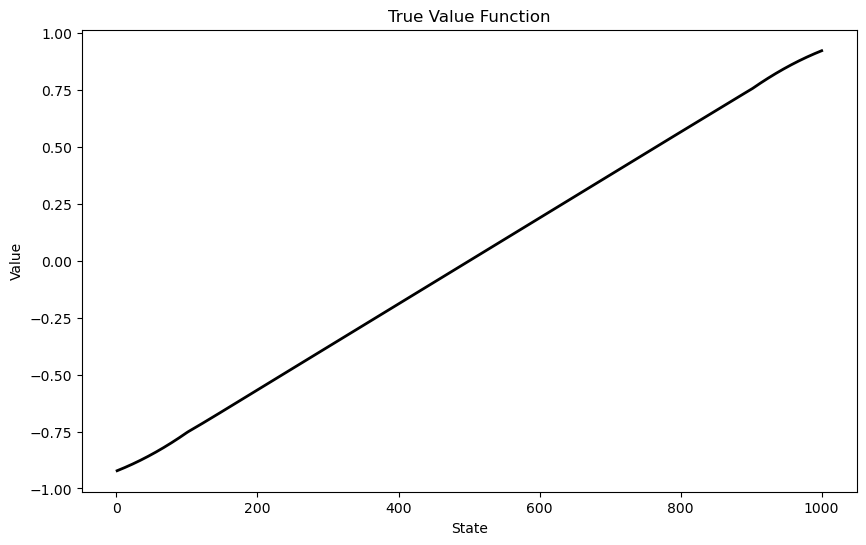

In [2]:

true_v = compute_true_value_function(n_states=1000, n_neighbors=100)
states = np.arange(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(states, true_v, label="True V", color="black", linewidth=2)
plt.title("True Value Function")
plt.xlabel("State")
plt.ylabel("Value")

Running Gradient MC with state aggregation...


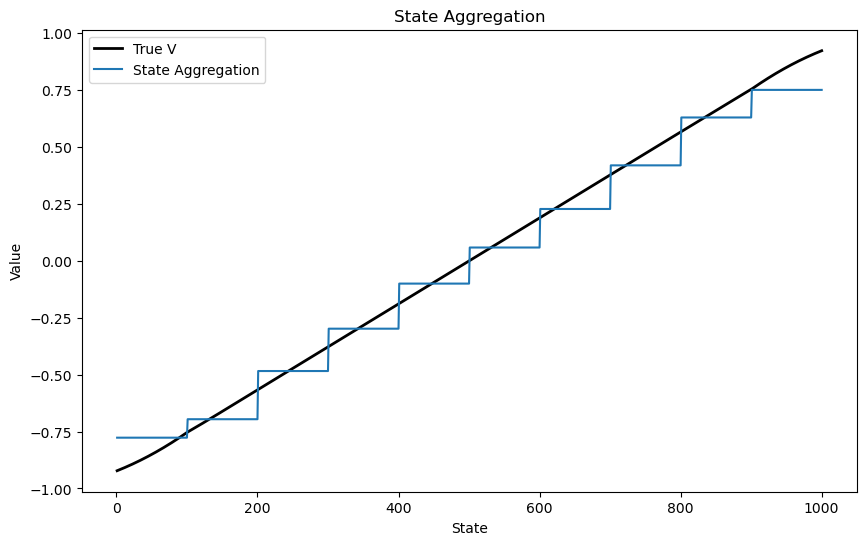

In [3]:
env = RandomWalk1000(n_states=1000, n_neighbors=100)
print("Running Gradient MC with state aggregation...")
alpha_agg = 2e-4
w_agg = gradient_mc(env, feature_fn=state_aggregation_feature, 
                    alpha=alpha_agg, n_episodes=5000)

approx_v_agg = np.array([
    np.dot(w_agg, state_aggregation_feature(s)) 
    for s in range(1, 1001)
])
states = np.arange(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(states, true_v, label="True V", color="black", linewidth=2)
plt.plot(states, approx_v_agg, label="State Aggregation")
plt.xlabel("State")
plt.ylabel("Value")
plt.title("State Aggregation")
plt.legend()
plt.show()